Here we are given a dataset of images that contain beet and thistle. The goal is to classify beet and thistle into two classes.

Since the images are given without their masks (labels), as far as i know it's not possible to do supervised learning. In this sense, i tried to perform unsupervised semantic segmantation. i found the following papers that discuss unserpervised classification/segmentation:

*   [W-Net: A Deep Model for Fully Unsupervised Image Segmentation](https://arxiv.org/abs/1711.08506)
*   [Invariant Information Clustering for Unsupervised Image Classification and Segmentation](https://arxiv.org/abs/1807.06653)
*   [Deep Clustering with Convolutional Autoencoders](https://xifengguo.github.io/papers/ICONIP17-DCEC.pdf)

Due to time constraints, i went for the last paper since it's much easier to understand and implement than the first ones.
The original paper was intended for classification. To make it work on semantic segmentation, i used a pach-wise training where several patches of size (32x32x3) were extracted and fed to a CNN model that was trained end-to-end.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.feature_extraction.image import extract_patches_2d
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.layers import Input, Dense, Conv2D,Conv2DTranspose,Reshape, MaxPooling2D,Activation
from keras.layers import concatenate,add, UpSampling2D,Flatten,Dropout,GaussianNoise
from keras.callbacks import  ModelCheckpoint,Callback,LearningRateScheduler,CSVLogger
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks

import cv2
from tqdm import tqdm
from glob import glob
import gc

In [0]:
# Reading Patch extraction

class Pipeline(object):
    
    def __init__(self, list_train ,Normalize=True):
        self.scans_train = list_train
        self.train_im=self.read_scans(Normalize)
        
    def read_scans(self,Normalize):

        '''
        func to read and normalise images
        '''
        train_im=[]
        for i in tqdm(self.scans_train):
            
            #read each image
            img = cv2.imread(i)

            #normalize images
            if Normalize==True:
              if np.std(img)!=0 :
                img= (img-np.mean(img))/np.std(img)

            train_im.append(img)  
        return  np.array(train_im).astype(np.float32)

    def patch_extraction (self,h,w,max_patches_per_image=None):
          '''
          func to extract patches and thus construc training dataset
          '''
          training=[]
          for i in tqdm(range(self.train_im.shape[0])):
            training.append(extract_patches_2d(self.train_im[i], (h, w),max_patches=max_patches_per_image))

          return np.array(training).reshape((-1,h,w,3)).astype(np.float32)


In [0]:
path_data=glob('gdrive/My Drive/beet_classification/data/*')
#path_data=sorted(path_data,key= lambda x:int(x.split('_')[-1][:-4]))

# since RAM doesn't sufice to load all patches at once, i splitted the dataset into two parts by saving to disk.
pipe=Pipeline(path_data[:480//2],Normalize=True)
train_part1=pipe.patch_extraction(32,32,max_patches_per_image=3000)
np.save('tr_part1',train_part1)
del train_part1,pipe
gc.collect()

pipe=Pipeline(path_data[480//2:],Normalize=True)
train_part2=pipe.patch_extraction(28,28,max_patches_per_image=3000)
np.save('tr_part2',train_part2)
del train_part2,pipe
gc.collect()


In [11]:
# Load training data

training=np.load("tr_part1.npy").astype(np.float32)
print(training.shape)

#training2=np.load("tr_part2.npy").astype(np.float32)
#print(training.shape)

#training=np.concatenate((training, training2), axis=0)
#print(training.shape)

(480000, 32, 32, 3)


### Models

In [0]:
# CNN model inspired from the paper: Deep Clustering with Convolutional Autoencoders
 
def autoencoderConv2D_1(input_shape=(32, 32, 3)):
    input_img = Input(shape=input_shape) 
    #add gaussian noise to the first layer to reduce overfitting
    i_=GaussianNoise(0.01)(input_img)

    encoded=Conv2D(32, 3, strides=2, padding='same', activation='relu')(i_)
    encoded=Conv2D(64, 3, strides=2, padding='same', activation='relu')(encoded)
    encoded=Conv2D(128, 3, strides=2, padding='same', activation='relu')(encoded)
    encoded=Conv2D(256, 3, strides=2, padding='same', activation='relu')(encoded)
    encoded=Flatten()(encoded)
    encoded=Dense(10,activation="relu")(encoded)

    decoded=Dense(1024, activation='relu')(encoded)
    decoded=Reshape((2, 2, 256))(decoded)
    decoded=Conv2DTranspose(128, 3, strides=2, padding="same", activation='relu')(decoded)
    decoded=Conv2DTranspose(64, 3, strides=2, padding="same", activation='relu')(decoded)
    decoded=Conv2DTranspose(32, 3, strides=2, padding="same", activation='relu')(decoded)
    decoded=Conv2DTranspose(3, 3, strides=2, padding="same")(decoded)
    
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [0]:
# CNN Auto Encoder with residual units
def res_block_enc(m,dim,bn=True,acti='relu',format_="channels_last"):
    
    """
    A residual Block
    """
    n = BatchNormalization()(m) if bn else n
    n=  Activation(acti)(n)
    #n=PReLU(shared_axes=[1, 2])(n)
    n = Conv2D(dim, 3, padding='same',data_format = format_)(n)
            
    n = BatchNormalization()(n) if bn else n
    n=  Activation(acti)(n)
    #n=PReLU(shared_axes=[1, 2])(n)
    n = Conv2D(dim, 3, padding='same',data_format = format_)(n)

    n=add([m,n]) 
    
    return  n 

 
def autoencoderRes(input_shape=(32, 32, 3)):

    input_img = Input(shape=input_shape) 
    #add gaussian noise to the first layer to reduce overfitting
    i_=GaussianNoise(0.01)(input_img)

    encoded=Conv2D(64, 2, padding='same')(i_)
    encoded=res_block_enc(encoded,64)
    encoded = Conv2D(128, 2,strides=2, padding='same')(encoded)
    encoded=res_block_enc(encoded,128)
    encoded = Conv2D(256, 2,strides=2, padding='same')(encoded)
    encoded=res_block_enc(encoded,256)

    encoded=Flatten()(encoded)
    encoded=Dense(10,activation="relu")(encoded)
    decoded=Dense(4096, activation='relu')(encoded)
    decoded=Reshape((4, 4, 256))(decoded)

    decoded=Conv2DTranspose(128, 3, strides=2, padding="same", activation='relu')(decoded)
    decoded=res_block_enc(decoded,128)
    decoded=Conv2DTranspose(64, 3, strides=2, padding="same", activation='relu')(decoded)
    decoded=res_block_enc(decoded,64)
    decoded=Conv2DTranspose(3, 3, strides=2, padding="same")(decoded)
    
    return   Model(inputs=input_img, outputs=decoded, name='AE'),Model(inputs=input_img, outputs=encoded, name='encoder')

### Training

In [0]:
# Train the model             
class SGDLearningRateTracker(Callback):
    def on_epoch_begin(self, epoch, logs={}):
      if epoch%3==0 and epoch!=0:
        optimizer = self.model.optimizer
        lr = K.get_value(optimizer.lr)
        #decay = K.get_value(optimizer.decay)
        lr=lr/2
        #decay=decay*2
        K.set_value(optimizer.lr, lr)
        #K.set_value(optimizer.decay, decay)

autoencoder, encoder = autoencoderRes()
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(training, training, batch_size=256, epochs=10,shuffle=True,validation_split=0.2,callbacks=[on_epoch_begin])

In [0]:
# save model weights
autoencoder.save_weights('ConvAE_weights.h5')

In [0]:
# Reference : https://github.com/XifengGuo/DCEC

class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
      
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [0]:
# Reference : https://github.com/XifengGuo/DCEC

n_clusters = 3 # for background, beet and thistle

# load wights and define model
autoencoder, encoder = autoencoderConv2D_1()
autoencoder.load_weights('ConvAE_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,outputs=[clustering_layer, autoencoder.output])

# Clustering with K-means/GMM

#gmm = GMM(n_components=n_clusters))
#y_pred = gmm.fit_predict(encoder.predict(training))
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(training))

#init the Clustering layer weights with K-means/GMM centers
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

#compile the model with Kullback–Leibler divergence and mean squared error losses
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

# Parameters set from the paper
loss = 0
index = 0
maxiter = 5000
update_interval = 140
index_array = np.arange(training.shape[0])

tol = 0.001 # tolerance threshold to stop training
batch_size=256

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        print('start prediction')
        print( 'loss=', np.round(loss, 5))
        q, _  = model.predict(training, verbose=1,batch_size=batch_size)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, training.shape[0])]
    loss = model.train_on_batch(x=training[idx], y=[p[idx], training[idx]])
    index = index + 1 if (index + 1) * batch_size <= training.shape[0] else 0


In [0]:
# Save mode weights
model.save_weights('model_final.h5')

### Prediction

In [0]:
def predict(model,path_imgs):
  y_pred=[]
  for i in tqdm(range(path_imgs.shape[0])):
    # Extract patches
    image_patches=extract_patches_2d(path_imgs[i], (32, 32))
    # Evalation
    q = model.predict(image_patches,batch_size=1024)
    mask=np.array(q[0]).argmax(-1)
    mask=mask.reshape(169,169)
    y_pred.append(mask)
  return np.array(y_pred)

In [93]:
# Load model weights
autoencoder, encoder = autoencoderConv2D_1()
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,outputs=[clustering_layer, autoencoder.output])
model.load_weights('model_final.h5')

# load images to test
path_data=glob('gdrive/My Drive/beet_classification/data/*')
path_data=sorted(path_data,key= lambda x:int(x.split('_')[-1][:-4]))
pipe=Pipeline(path_data,Normalize=True)

100%|██████████| 480/480 [00:02<00:00, 164.83it/s]


100%|██████████| 1/1 [00:10<00:00, 10.03s/it]


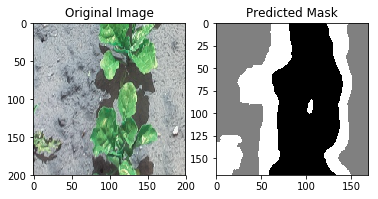

In [112]:
# Prediction and visualisation
image_id=397
images=pipe.train_im[image_id:image_id+1]
mask=predict(model,images)

#Visualisation of original image and the predicted mask
fig = plt.figure()
ax1=fig.add_subplot(1,2,1)
ax1.title.set_text('Original Image')
plt.imshow(cv2.imread(pipe.scans_train[image_id]))
ax2=fig.add_subplot(1,2,2)
ax2.title.set_text('Predicted Mask')
plt.imshow(img)

In [0]:
# Visualize mutiple images

start_image=10
n=35
images=pipe.train_im[start_image:start_image+n]
masks=predict(model,images)


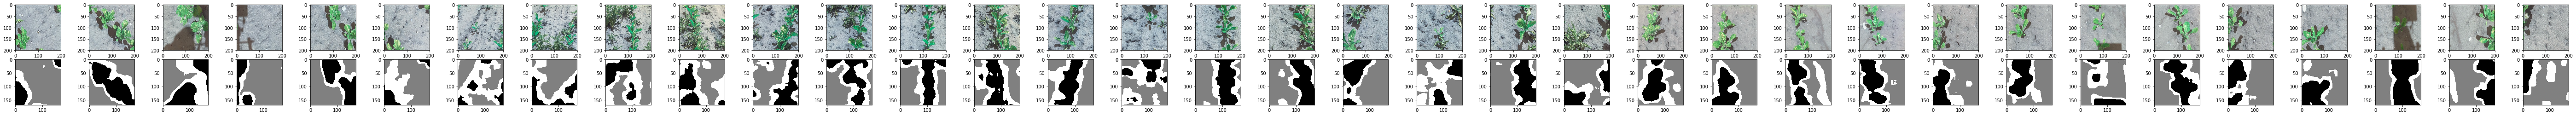

In [122]:
plt.figure(figsize=(100, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cv2.imread(pipe.scans_train[start_image+i]))
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(masks[i])
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)

The predictions found by our model aren't good. Even though the model yielded good results when it comes to distinuishing plants and background. It failed to classify beet and thistle.

The following things could improve the results :

*   Data Augmentation with horizontal/vertical flipping, rotation, translation...
*   Use Excess green index (ExG) to seperate plant from backgound then use this as a mask to extract patchs.
* Use more complex methods (first two papers).




In [0]:
'''
def excess_green_index(image):
      R = image[:,:,0]
      G = image[:,:,1]
      B = image[:,:,2]

      out=2*G - R - B

      #out=cv2.cvtColor(out,cv2.COLOR_GRAY2BGR)
      #out=cv2.cvtColor(out,cv2.COLOR_BGR2GRAY)
      #_,out = cv2.threshold(out,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

      #out = cv2.medianBlur(out, 5)
      return out 
'''   